In [1]:
import pandas as pd
from glob import glob
from tqdm import tqdm
import json
from model_training_process import *
import requests
import matplotlib.pyplot as plt
import os

In [2]:
class_df = pd.read_csv("..\\tables\\corrected_class_df_pinyin_label_table.csv")
class_df[["pinyin", "class_label"]]

,pinyin,class_label
0,zhi,0
1,chi,0
2,shi,0
3,ri,0
4,zi,1
...,...,...
402,xun,20
403,yong,18
404,jiong,20
405,qiong,20


In [3]:
class_df['class_label_index'] = class_df.groupby('class_label').cumcount()
class_df[["pinyin", "class_label", "class_label_index"]]

,pinyin,class_label,class_label_index
0,zhi,0,0
1,chi,0,1
2,shi,0,2
3,ri,0,3
4,zi,1,0
...,...,...,...
402,xun,20,11
403,yong,18,4
404,jiong,20,12
405,qiong,20,13


In [4]:
npy_file_path_list = glob("..\\..\\data\\*EduVer\\*")
print(f"len(npy_file_path_list): {len(npy_file_path_list)}")

len(npy_file_path_list): 67173


In [5]:
selected_npy_file_path_list = list()
for npy_file_path in npy_file_path_list:
    pinyin = npy_file_path.split("_")[1]
    pinyin_non_accent = pinyin[:-1] if pinyin[-1].isdigit() else pinyin
    if pinyin_non_accent in list(class_df["pinyin"]):
        selected_npy_file_path_list.append(npy_file_path)
print(f"len(npy_file_path_selected): {len(selected_npy_file_path_list)}")

len(npy_file_path_selected): 66852


In [6]:
print(len(class_df.groupby("class_label").count().index))
class_df.groupby("class_label").count().index

21


Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20],
      dtype='int64', name='class_label')

In [7]:
dic = dict()

for i in range(len(class_df.groupby("class_label").count().index)):
    dic[f"class_{i}_mfcc_matrix_list"] = list()
    dic[f"class_{i}_class_label_index_list"] = list()

for npy_file_path in tqdm(selected_npy_file_path_list):
    pinyin = npy_file_path.split("_")[1]
    pinyin_non_accent = pinyin[:-1] if pinyin[-1].isdigit() else pinyin

    class_label = class_df.loc[class_df["pinyin"] == pinyin_non_accent, "class_label"].values[0]
    class_label_index = class_df.loc[class_df["pinyin"] == pinyin_non_accent, "class_label_index"].values[0]
    # print(f"{pinyin_non_accent}, {class_label}, {class_label_index}")

    mfcc_matrix = np.load(npy_file_path)
    dic[f"class_{class_label}_mfcc_matrix_list"].append(mfcc_matrix)
    dic[f"class_{class_label}_class_label_index_list"].append(class_label_index)

for i in range(len(class_df.groupby("class_label").count().index)):
    dic[f"class_{i}_mfcc_matrix_list"] = np.array(dic[f"class_{i}_mfcc_matrix_list"])
    dic[f"class_{i}_class_label_index_list"] = np.array(dic[f"class_{i}_class_label_index_list"])

for i in range(len(class_df.groupby("class_label").count().index)):
    print(f"class_{i}_mfcc_matrix_list.shape: {dic[f'class_{i}_mfcc_matrix_list'].shape}")
    print(f"class_{i}_class_label_index_list.shape: {dic[f'class_{i}_class_label_index_list'].shape}")

100%|██████████| 66852/66852 [00:43<00:00, 1540.78it/s]


class_0_mfcc_matrix_list.shape: (3133, 13, 44)
class_0_class_label_index_list.shape: (3133,)
class_1_mfcc_matrix_list.shape: (844, 13, 44)
class_1_class_label_index_list.shape: (844,)
class_2_mfcc_matrix_list.shape: (1322, 13, 44)
class_2_class_label_index_list.shape: (1322,)
class_3_mfcc_matrix_list.shape: (5333, 13, 44)
class_3_class_label_index_list.shape: (5333,)
class_4_mfcc_matrix_list.shape: (7255, 13, 44)
class_4_class_label_index_list.shape: (7255,)
class_5_mfcc_matrix_list.shape: (4499, 13, 44)
class_5_class_label_index_list.shape: (4499,)
class_6_mfcc_matrix_list.shape: (6060, 13, 44)
class_6_class_label_index_list.shape: (6060,)
class_7_mfcc_matrix_list.shape: (3050, 13, 44)
class_7_class_label_index_list.shape: (3050,)
class_8_mfcc_matrix_list.shape: (3167, 13, 44)
class_8_class_label_index_list.shape: (3167,)
class_9_mfcc_matrix_list.shape: (2396, 13, 44)
class_9_class_label_index_list.shape: (2396,)
class_10_mfcc_matrix_list.shape: (4181, 13, 44)
class_10_class_label_ind

In [8]:
channel = 1
verbose = 2
num_classes = len(class_df.index)
test_size = 0.2

In [9]:
model_train_info_list = list()
model_list = list()

for i in tqdm(range(len(class_df.groupby("class_label").count().index))):
    
    best_params = json.load(
        open(
            file=f"..\\..\\grid_search\\method1_with_fake_data\\best_parameters_record\\best_parameters_class{i}.json",
            mode="r"
        )
    )

    learning_rate = best_params["learning_rate"]
    num_filters = best_params["num_filters"]
    dense_units = best_params["dense_unit"]
    batch_size = best_params["batch_size"]
    epochs = best_params["epochs"]
    
    X = dic[f"class_{i}_mfcc_matrix_list"]
    y = dic[f"class_{i}_class_label_index_list"]
    
    mfcc_dim_1 = X.shape[1]
    mfcc_dim_2 = X.shape[2]
    
    X_train, X_test, y_train, y_test = get_processed_data(
        X=X,
        y=y,
        num_classes=num_classes,
        mfcc_dim_1=mfcc_dim_1,
        mfcc_dim_2=mfcc_dim_2,
        channel=channel,
        test_size=test_size,
    )

    model = get_cnn_model(
        input_shape=(mfcc_dim_1, mfcc_dim_2, channel),
        num_classes=num_classes,
        learning_rate=learning_rate,
        num_filters=num_filters,
        dense_units=dense_units
    )
    
    model_train_info = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=verbose,
        validation_data=(X_test, y_test)
    )
    
    model_train_info_list.append(model_train_info)
    model_list.append(model)

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/250
20/20 - 1s - loss: 5.4949 - accuracy: 0.2662 - val_loss: 5.8378 - val_accuracy: 0.6571 - 1s/epoch - 75ms/step
Epoch 2/250
20/20 - 0s - loss: 4.2037 - accuracy: 0.6209 - val_loss: 5.5703 - val_accuracy: 0.6603 - 222ms/epoch - 11ms/step
Epoch 3/250
20/20 - 0s - loss: 3.0126 - accuracy: 0.6397 - val_loss: 5.1895 - val_accuracy: 0.0750 - 217ms/epoch - 11ms/step
Epoch 4/250
20/20 - 0s - loss: 2.1393 - accuracy: 0.6816 - val_loss: 4.6809 - val_accuracy: 0.0670 - 217ms/epoch - 11ms/step
Epoch 5/250
20/20 - 0s - loss: 1.5290 - accuracy: 0.7394 - val_loss: 4.0852 - val_accuracy: 0.4322 - 220ms/epoch - 11ms/step
Epoch 6/250
20/20 - 0s - loss: 1.0861 - accuracy: 0.7841 - val_loss: 3.5805 - val_accuracy: 0.3923 - 216ms/epoch - 11ms/step
Epoch 7/250
20/20 - 0s - loss: 0.9088 - accuracy: 0.7993 - val_loss: 3.0681 - val_accuracy: 0.6667 - 218ms/epoch - 11ms/step
Epoch 8/250
20/20 - 0s - loss: 0.7483 - accuracy: 0.8073 - val_loss: 2.5753 - val_accuracy: 0.6683 - 221ms/epoch - 11ms/step
Epo

  5%|▍         | 1/21 [00:58<19:38, 58.90s/it]

Epoch 1/250
6/6 - 1s - loss: 5.7836 - accuracy: 0.1467 - val_loss: 5.9821 - val_accuracy: 0.0000e+00 - 807ms/epoch - 134ms/step
Epoch 2/250
6/6 - 0s - loss: 5.0197 - accuracy: 0.4104 - val_loss: 5.9175 - val_accuracy: 0.2544 - 73ms/epoch - 12ms/step
Epoch 3/250
6/6 - 0s - loss: 4.4805 - accuracy: 0.4548 - val_loss: 5.8229 - val_accuracy: 0.2722 - 73ms/epoch - 12ms/step
Epoch 4/250
6/6 - 0s - loss: 3.9800 - accuracy: 0.4948 - val_loss: 5.7118 - val_accuracy: 0.2781 - 71ms/epoch - 12ms/step
Epoch 5/250
6/6 - 0s - loss: 3.5410 - accuracy: 0.5319 - val_loss: 5.5939 - val_accuracy: 0.2781 - 80ms/epoch - 13ms/step
Epoch 6/250
6/6 - 0s - loss: 3.2496 - accuracy: 0.5348 - val_loss: 5.4569 - val_accuracy: 0.2781 - 78ms/epoch - 13ms/step
Epoch 7/250
6/6 - 0s - loss: 2.8873 - accuracy: 0.5511 - val_loss: 5.2987 - val_accuracy: 0.2781 - 75ms/epoch - 12ms/step
Epoch 8/250
6/6 - 0s - loss: 2.6279 - accuracy: 0.5719 - val_loss: 5.1292 - val_accuracy: 0.2781 - 62ms/epoch - 10ms/step
Epoch 9/250
6/6 - 

 10%|▉         | 2/21 [01:18<11:21, 35.85s/it]

Epoch 1/250
9/9 - 1s - loss: 5.4042 - accuracy: 0.2204 - val_loss: 5.9959 - val_accuracy: 0.0566 - 760ms/epoch - 84ms/step
Epoch 2/250
9/9 - 0s - loss: 4.2371 - accuracy: 0.3254 - val_loss: 5.9629 - val_accuracy: 0.0642 - 104ms/epoch - 12ms/step
Epoch 3/250
9/9 - 0s - loss: 3.7824 - accuracy: 0.3548 - val_loss: 5.9022 - val_accuracy: 0.0642 - 105ms/epoch - 12ms/step
Epoch 4/250
9/9 - 0s - loss: 3.4147 - accuracy: 0.3813 - val_loss: 5.8127 - val_accuracy: 0.0642 - 108ms/epoch - 12ms/step
Epoch 5/250
9/9 - 0s - loss: 3.0745 - accuracy: 0.4115 - val_loss: 5.6887 - val_accuracy: 0.0642 - 101ms/epoch - 11ms/step
Epoch 6/250
9/9 - 0s - loss: 2.8256 - accuracy: 0.4418 - val_loss: 5.5395 - val_accuracy: 0.0642 - 106ms/epoch - 12ms/step
Epoch 7/250
9/9 - 0s - loss: 2.6185 - accuracy: 0.4447 - val_loss: 5.3683 - val_accuracy: 0.0642 - 104ms/epoch - 12ms/step
Epoch 8/250
9/9 - 0s - loss: 2.4322 - accuracy: 0.4598 - val_loss: 5.1672 - val_accuracy: 0.0566 - 106ms/epoch - 12ms/step
Epoch 9/250
9/9 

 14%|█▍        | 3/21 [01:46<09:40, 32.22s/it]

Epoch 1/250
34/34 - 1s - loss: 5.1669 - accuracy: 0.1294 - val_loss: 5.8721 - val_accuracy: 0.0150 - 1s/epoch - 30ms/step
Epoch 2/250
34/34 - 0s - loss: 3.7105 - accuracy: 0.2450 - val_loss: 5.4867 - val_accuracy: 0.0150 - 379ms/epoch - 11ms/step
Epoch 3/250
34/34 - 0s - loss: 3.0037 - accuracy: 0.3050 - val_loss: 4.9555 - val_accuracy: 0.0169 - 370ms/epoch - 11ms/step
Epoch 4/250
34/34 - 0s - loss: 2.6352 - accuracy: 0.3584 - val_loss: 4.5074 - val_accuracy: 0.0206 - 376ms/epoch - 11ms/step
Epoch 5/250
34/34 - 0s - loss: 2.4057 - accuracy: 0.3966 - val_loss: 4.2138 - val_accuracy: 0.0562 - 363ms/epoch - 11ms/step
Epoch 6/250
34/34 - 0s - loss: 2.2436 - accuracy: 0.4292 - val_loss: 4.0210 - val_accuracy: 0.0797 - 371ms/epoch - 11ms/step
Epoch 7/250
34/34 - 0s - loss: 2.1130 - accuracy: 0.4620 - val_loss: 3.9082 - val_accuracy: 0.1078 - 362ms/epoch - 11ms/step
Epoch 8/250
34/34 - 0s - loss: 2.0140 - accuracy: 0.4852 - val_loss: 3.7626 - val_accuracy: 0.1284 - 371ms/epoch - 11ms/step
Epo

 19%|█▉        | 4/21 [03:30<17:06, 60.38s/it]

Epoch 1/250
46/46 - 1s - loss: 4.3598 - accuracy: 0.2932 - val_loss: 5.8709 - val_accuracy: 0.0131 - 1s/epoch - 27ms/step
Epoch 2/250
46/46 - 1s - loss: 2.6888 - accuracy: 0.4223 - val_loss: 5.3532 - val_accuracy: 0.0172 - 504ms/epoch - 11ms/step
Epoch 3/250
46/46 - 1s - loss: 2.1255 - accuracy: 0.4819 - val_loss: 4.7982 - val_accuracy: 0.0186 - 504ms/epoch - 11ms/step
Epoch 4/250
46/46 - 1s - loss: 1.8644 - accuracy: 0.5214 - val_loss: 4.4499 - val_accuracy: 0.0179 - 511ms/epoch - 11ms/step
Epoch 5/250
46/46 - 1s - loss: 1.7003 - accuracy: 0.5548 - val_loss: 4.1278 - val_accuracy: 0.0600 - 507ms/epoch - 11ms/step
Epoch 6/250
46/46 - 1s - loss: 1.5886 - accuracy: 0.5817 - val_loss: 3.8702 - val_accuracy: 0.1440 - 527ms/epoch - 11ms/step
Epoch 7/250
46/46 - 0s - loss: 1.4590 - accuracy: 0.6122 - val_loss: 3.6048 - val_accuracy: 0.1316 - 491ms/epoch - 11ms/step
Epoch 8/250
46/46 - 0s - loss: 1.3538 - accuracy: 0.6575 - val_loss: 3.3335 - val_accuracy: 0.1482 - 497ms/epoch - 11ms/step
Epo

 24%|██▍       | 5/21 [05:37<22:33, 84.60s/it]

Epoch 1/250
29/29 - 1s - loss: 5.0595 - accuracy: 0.1906 - val_loss: 5.9176 - val_accuracy: 0.0233 - 926ms/epoch - 32ms/step
Epoch 2/250
29/29 - 0s - loss: 3.5386 - accuracy: 0.3126 - val_loss: 5.6186 - val_accuracy: 0.0111 - 319ms/epoch - 11ms/step
Epoch 3/250
29/29 - 0s - loss: 2.7905 - accuracy: 0.3751 - val_loss: 5.1403 - val_accuracy: 0.0222 - 313ms/epoch - 11ms/step
Epoch 4/250
29/29 - 0s - loss: 2.3748 - accuracy: 0.4171 - val_loss: 4.6314 - val_accuracy: 0.0200 - 311ms/epoch - 11ms/step
Epoch 5/250
29/29 - 0s - loss: 2.1531 - accuracy: 0.4387 - val_loss: 4.1988 - val_accuracy: 0.1656 - 307ms/epoch - 11ms/step
Epoch 6/250
29/29 - 0s - loss: 1.9677 - accuracy: 0.4776 - val_loss: 3.9053 - val_accuracy: 0.1678 - 311ms/epoch - 11ms/step
Epoch 7/250
29/29 - 0s - loss: 1.8213 - accuracy: 0.5076 - val_loss: 3.7252 - val_accuracy: 0.1722 - 310ms/epoch - 11ms/step
Epoch 8/250
29/29 - 0s - loss: 1.7047 - accuracy: 0.5354 - val_loss: 3.5936 - val_accuracy: 0.1911 - 311ms/epoch - 11ms/step


 29%|██▊       | 6/21 [06:56<20:40, 82.72s/it]

Epoch 1/250
38/38 - 1s - loss: 4.7339 - accuracy: 0.2415 - val_loss: 5.8673 - val_accuracy: 0.0206 - 1s/epoch - 31ms/step
Epoch 2/250
38/38 - 0s - loss: 3.1043 - accuracy: 0.3614 - val_loss: 5.4293 - val_accuracy: 0.0206 - 408ms/epoch - 11ms/step
Epoch 3/250
38/38 - 0s - loss: 2.4312 - accuracy: 0.4356 - val_loss: 4.8894 - val_accuracy: 0.0248 - 410ms/epoch - 11ms/step
Epoch 4/250
38/38 - 0s - loss: 2.1154 - accuracy: 0.4755 - val_loss: 4.4360 - val_accuracy: 0.0231 - 426ms/epoch - 11ms/step
Epoch 5/250
38/38 - 0s - loss: 1.9104 - accuracy: 0.5074 - val_loss: 4.1044 - val_accuracy: 0.0470 - 409ms/epoch - 11ms/step
Epoch 6/250
38/38 - 0s - loss: 1.7552 - accuracy: 0.5402 - val_loss: 3.8876 - val_accuracy: 0.1015 - 411ms/epoch - 11ms/step
Epoch 7/250
38/38 - 0s - loss: 1.6057 - accuracy: 0.5873 - val_loss: 3.6833 - val_accuracy: 0.0701 - 410ms/epoch - 11ms/step
Epoch 8/250
38/38 - 0s - loss: 1.4566 - accuracy: 0.6592 - val_loss: 3.4835 - val_accuracy: 0.0611 - 408ms/epoch - 11ms/step
Epo

 33%|███▎      | 7/21 [08:40<20:54, 89.63s/it]

Epoch 1/250
20/20 - 1s - loss: 5.3183 - accuracy: 0.1721 - val_loss: 5.9970 - val_accuracy: 0.0279 - 803ms/epoch - 40ms/step
Epoch 2/250
20/20 - 0s - loss: 4.0222 - accuracy: 0.2918 - val_loss: 5.9058 - val_accuracy: 0.0393 - 204ms/epoch - 10ms/step
Epoch 3/250
20/20 - 0s - loss: 3.3308 - accuracy: 0.3324 - val_loss: 5.7130 - val_accuracy: 0.0377 - 221ms/epoch - 11ms/step
Epoch 4/250
20/20 - 0s - loss: 2.8561 - accuracy: 0.3717 - val_loss: 5.4475 - val_accuracy: 0.0180 - 203ms/epoch - 10ms/step
Epoch 5/250
20/20 - 0s - loss: 2.5570 - accuracy: 0.3930 - val_loss: 5.1520 - val_accuracy: 0.0164 - 219ms/epoch - 11ms/step
Epoch 6/250
20/20 - 0s - loss: 2.3959 - accuracy: 0.4111 - val_loss: 4.8851 - val_accuracy: 0.0164 - 221ms/epoch - 11ms/step
Epoch 7/250
20/20 - 0s - loss: 2.2421 - accuracy: 0.4291 - val_loss: 4.6760 - val_accuracy: 0.0164 - 203ms/epoch - 10ms/step
Epoch 8/250
20/20 - 0s - loss: 2.1290 - accuracy: 0.4488 - val_loss: 4.5118 - val_accuracy: 0.0361 - 225ms/epoch - 11ms/step


 38%|███▊      | 8/21 [09:35<17:01, 78.57s/it]

Epoch 1/250
20/20 - 1s - loss: 4.6206 - accuracy: 0.4078 - val_loss: 5.9417 - val_accuracy: 0.0158 - 992ms/epoch - 50ms/step
Epoch 2/250
20/20 - 0s - loss: 2.9212 - accuracy: 0.5282 - val_loss: 5.7695 - val_accuracy: 0.0836 - 221ms/epoch - 11ms/step
Epoch 3/250
20/20 - 0s - loss: 2.1087 - accuracy: 0.5957 - val_loss: 5.4519 - val_accuracy: 0.0836 - 219ms/epoch - 11ms/step
Epoch 4/250
20/20 - 0s - loss: 1.6126 - accuracy: 0.6380 - val_loss: 5.0043 - val_accuracy: 0.0836 - 219ms/epoch - 11ms/step
Epoch 5/250
20/20 - 0s - loss: 1.2984 - accuracy: 0.6747 - val_loss: 4.5239 - val_accuracy: 0.0836 - 220ms/epoch - 11ms/step
Epoch 6/250
20/20 - 0s - loss: 1.1072 - accuracy: 0.7031 - val_loss: 4.0264 - val_accuracy: 0.0883 - 219ms/epoch - 11ms/step
Epoch 7/250
20/20 - 0s - loss: 0.9806 - accuracy: 0.7248 - val_loss: 3.6572 - val_accuracy: 0.0868 - 221ms/epoch - 11ms/step
Epoch 8/250
20/20 - 0s - loss: 0.8847 - accuracy: 0.7454 - val_loss: 3.3447 - val_accuracy: 0.1341 - 219ms/epoch - 11ms/step


 43%|████▎     | 9/21 [10:31<14:17, 71.46s/it]

Epoch 1/250
15/15 - 1s - loss: 5.3714 - accuracy: 0.1571 - val_loss: 5.9586 - val_accuracy: 0.0458 - 1s/epoch - 71ms/step
Epoch 2/250
15/15 - 0s - loss: 4.2113 - accuracy: 0.2641 - val_loss: 5.8304 - val_accuracy: 0.0208 - 157ms/epoch - 10ms/step
Epoch 3/250
15/15 - 0s - loss: 3.4843 - accuracy: 0.3126 - val_loss: 5.6118 - val_accuracy: 0.0229 - 159ms/epoch - 11ms/step
Epoch 4/250
15/15 - 0s - loss: 2.9765 - accuracy: 0.3455 - val_loss: 5.3249 - val_accuracy: 0.0229 - 171ms/epoch - 11ms/step
Epoch 5/250
15/15 - 0s - loss: 2.6158 - accuracy: 0.3800 - val_loss: 5.0077 - val_accuracy: 0.0229 - 172ms/epoch - 11ms/step
Epoch 6/250
15/15 - 0s - loss: 2.3361 - accuracy: 0.4160 - val_loss: 4.6815 - val_accuracy: 0.0229 - 174ms/epoch - 12ms/step
Epoch 7/250
15/15 - 0s - loss: 2.1349 - accuracy: 0.4442 - val_loss: 4.3533 - val_accuracy: 0.0229 - 157ms/epoch - 10ms/step
Epoch 8/250
15/15 - 0s - loss: 1.9613 - accuracy: 0.4828 - val_loss: 4.0804 - val_accuracy: 0.0229 - 169ms/epoch - 11ms/step
Epo

 48%|████▊     | 10/21 [11:14<11:30, 62.78s/it]

Epoch 1/250
27/27 - 1s - loss: 4.9804 - accuracy: 0.1821 - val_loss: 5.9084 - val_accuracy: 0.0287 - 882ms/epoch - 33ms/step
Epoch 2/250
27/27 - 0s - loss: 3.5361 - accuracy: 0.2886 - val_loss: 5.6397 - val_accuracy: 0.0191 - 293ms/epoch - 11ms/step
Epoch 3/250
27/27 - 0s - loss: 2.8202 - accuracy: 0.3627 - val_loss: 5.2353 - val_accuracy: 0.0191 - 284ms/epoch - 11ms/step
Epoch 4/250
27/27 - 0s - loss: 2.3914 - accuracy: 0.4202 - val_loss: 4.7837 - val_accuracy: 0.0251 - 300ms/epoch - 11ms/step
Epoch 5/250
27/27 - 0s - loss: 2.1340 - accuracy: 0.4635 - val_loss: 4.3852 - val_accuracy: 0.0311 - 281ms/epoch - 10ms/step
Epoch 6/250
27/27 - 0s - loss: 1.9599 - accuracy: 0.4880 - val_loss: 4.0725 - val_accuracy: 0.0311 - 300ms/epoch - 11ms/step
Epoch 7/250
27/27 - 0s - loss: 1.8452 - accuracy: 0.5048 - val_loss: 3.8496 - val_accuracy: 0.0346 - 281ms/epoch - 10ms/step
Epoch 8/250
27/27 - 0s - loss: 1.7221 - accuracy: 0.5440 - val_loss: 3.6739 - val_accuracy: 0.0920 - 298ms/epoch - 11ms/step


 52%|█████▏    | 11/21 [12:28<11:00, 66.08s/it]

Epoch 1/250
49/49 - 1s - loss: 4.4975 - accuracy: 0.2360 - val_loss: 5.7004 - val_accuracy: 0.0182 - 1s/epoch - 22ms/step
Epoch 2/250
49/49 - 1s - loss: 2.6073 - accuracy: 0.3758 - val_loss: 4.9004 - val_accuracy: 0.0189 - 519ms/epoch - 11ms/step
Epoch 3/250
49/49 - 1s - loss: 2.0265 - accuracy: 0.4462 - val_loss: 4.1678 - val_accuracy: 0.0195 - 520ms/epoch - 11ms/step
Epoch 4/250
49/49 - 1s - loss: 1.7709 - accuracy: 0.4906 - val_loss: 3.7184 - val_accuracy: 0.0794 - 519ms/epoch - 11ms/step
Epoch 5/250
49/49 - 1s - loss: 1.6025 - accuracy: 0.5258 - val_loss: 3.4520 - val_accuracy: 0.0709 - 519ms/epoch - 11ms/step
Epoch 6/250
49/49 - 1s - loss: 1.4738 - accuracy: 0.5712 - val_loss: 3.1742 - val_accuracy: 0.1204 - 519ms/epoch - 11ms/step
Epoch 7/250
49/49 - 1s - loss: 1.3314 - accuracy: 0.6226 - val_loss: 2.9960 - val_accuracy: 0.1607 - 520ms/epoch - 11ms/step
Epoch 8/250
49/49 - 1s - loss: 1.1839 - accuracy: 0.6942 - val_loss: 3.1042 - val_accuracy: 0.1405 - 519ms/epoch - 11ms/step
Epo

 57%|█████▋    | 12/21 [14:39<12:52, 85.87s/it]

Epoch 1/250
12/12 - 1s - loss: 5.4872 - accuracy: 0.2411 - val_loss: 6.0033 - val_accuracy: 0.0216 - 836ms/epoch - 70ms/step
Epoch 2/250
12/12 - 0s - loss: 4.0379 - accuracy: 0.4369 - val_loss: 5.9660 - val_accuracy: 0.0458 - 133ms/epoch - 11ms/step
Epoch 3/250
12/12 - 0s - loss: 3.1251 - accuracy: 0.4990 - val_loss: 5.8689 - val_accuracy: 0.0512 - 128ms/epoch - 11ms/step
Epoch 4/250
12/12 - 0s - loss: 2.4674 - accuracy: 0.5490 - val_loss: 5.7046 - val_accuracy: 0.0512 - 142ms/epoch - 12ms/step
Epoch 5/250
12/12 - 0s - loss: 2.0095 - accuracy: 0.6104 - val_loss: 5.4904 - val_accuracy: 0.0512 - 125ms/epoch - 10ms/step
Epoch 6/250
12/12 - 0s - loss: 1.6764 - accuracy: 0.6361 - val_loss: 5.2231 - val_accuracy: 0.0512 - 141ms/epoch - 12ms/step
Epoch 7/250
12/12 - 0s - loss: 1.4475 - accuracy: 0.6644 - val_loss: 4.9405 - val_accuracy: 0.0512 - 127ms/epoch - 11ms/step
Epoch 8/250
12/12 - 0s - loss: 1.2752 - accuracy: 0.6847 - val_loss: 4.6492 - val_accuracy: 0.0512 - 141ms/epoch - 12ms/step


 62%|██████▏   | 13/21 [15:13<09:22, 70.35s/it]

Epoch 1/250
6/6 - 1s - loss: 5.6041 - accuracy: 0.3103 - val_loss: 6.0037 - val_accuracy: 0.0000e+00 - 711ms/epoch - 119ms/step
Epoch 2/250
6/6 - 0s - loss: 4.4868 - accuracy: 0.5588 - val_loss: 5.9924 - val_accuracy: 0.0409 - 79ms/epoch - 13ms/step
Epoch 3/250
6/6 - 0s - loss: 3.7509 - accuracy: 0.5632 - val_loss: 5.9718 - val_accuracy: 0.0468 - 63ms/epoch - 10ms/step
Epoch 4/250
6/6 - 0s - loss: 3.2256 - accuracy: 0.5956 - val_loss: 5.9325 - val_accuracy: 0.0526 - 79ms/epoch - 13ms/step
Epoch 5/250
6/6 - 0s - loss: 2.8286 - accuracy: 0.6324 - val_loss: 5.8753 - val_accuracy: 0.0526 - 62ms/epoch - 10ms/step
Epoch 6/250
6/6 - 0s - loss: 2.4800 - accuracy: 0.6647 - val_loss: 5.7927 - val_accuracy: 0.0526 - 64ms/epoch - 11ms/step
Epoch 7/250
6/6 - 0s - loss: 2.2035 - accuracy: 0.6735 - val_loss: 5.6817 - val_accuracy: 0.0526 - 63ms/epoch - 10ms/step
Epoch 8/250
6/6 - 0s - loss: 1.9819 - accuracy: 0.6779 - val_loss: 5.5514 - val_accuracy: 0.0526 - 79ms/epoch - 13ms/step
Epoch 9/250
6/6 - 

 67%|██████▋   | 14/21 [15:32<06:23, 54.74s/it]

Epoch 1/250
17/17 - 1s - loss: 5.4180 - accuracy: 0.1594 - val_loss: 5.9609 - val_accuracy: 0.0151 - 897ms/epoch - 53ms/step
Epoch 2/250
17/17 - 0s - loss: 4.1577 - accuracy: 0.2637 - val_loss: 5.8204 - val_accuracy: 0.0151 - 186ms/epoch - 11ms/step
Epoch 3/250
17/17 - 0s - loss: 3.3735 - accuracy: 0.3226 - val_loss: 5.5840 - val_accuracy: 0.0151 - 190ms/epoch - 11ms/step
Epoch 4/250
17/17 - 0s - loss: 2.8405 - accuracy: 0.3840 - val_loss: 5.2767 - val_accuracy: 0.0151 - 188ms/epoch - 11ms/step
Epoch 5/250
17/17 - 0s - loss: 2.4551 - accuracy: 0.4335 - val_loss: 4.9342 - val_accuracy: 0.0151 - 190ms/epoch - 11ms/step
Epoch 6/250
17/17 - 0s - loss: 2.1929 - accuracy: 0.4722 - val_loss: 4.5940 - val_accuracy: 0.0358 - 188ms/epoch - 11ms/step
Epoch 7/250
17/17 - 0s - loss: 2.0157 - accuracy: 0.4821 - val_loss: 4.2704 - val_accuracy: 0.0320 - 187ms/epoch - 11ms/step
Epoch 8/250
17/17 - 0s - loss: 1.8547 - accuracy: 0.5179 - val_loss: 3.9796 - val_accuracy: 0.0546 - 189ms/epoch - 11ms/step


 71%|███████▏  | 15/21 [16:20<05:16, 52.73s/it]

Epoch 1/250
23/23 - 1s - loss: 5.2448 - accuracy: 0.1574 - val_loss: 5.9353 - val_accuracy: 0.0432 - 1s/epoch - 45ms/step
Epoch 2/250
23/23 - 0s - loss: 3.8804 - accuracy: 0.2861 - val_loss: 5.7167 - val_accuracy: 0.0195 - 250ms/epoch - 11ms/step
Epoch 3/250
23/23 - 0s - loss: 3.1316 - accuracy: 0.3444 - val_loss: 5.3680 - val_accuracy: 0.0195 - 258ms/epoch - 11ms/step
Epoch 4/250
23/23 - 0s - loss: 2.6655 - accuracy: 0.3859 - val_loss: 4.9539 - val_accuracy: 0.0404 - 245ms/epoch - 11ms/step
Epoch 5/250
23/23 - 0s - loss: 2.3614 - accuracy: 0.4135 - val_loss: 4.5578 - val_accuracy: 0.0725 - 252ms/epoch - 11ms/step
Epoch 6/250
23/23 - 0s - loss: 2.1778 - accuracy: 0.4456 - val_loss: 4.2150 - val_accuracy: 0.0307 - 234ms/epoch - 10ms/step
Epoch 7/250
23/23 - 0s - loss: 2.0363 - accuracy: 0.4662 - val_loss: 3.9566 - val_accuracy: 0.0237 - 238ms/epoch - 10ms/step
Epoch 8/250
23/23 - 0s - loss: 1.9128 - accuracy: 0.4853 - val_loss: 3.7956 - val_accuracy: 0.0293 - 250ms/epoch - 11ms/step
Epo

 76%|███████▌  | 16/21 [17:23<04:38, 55.80s/it]

Epoch 1/250
23/23 - 1s - loss: 5.2221 - accuracy: 0.1844 - val_loss: 5.9715 - val_accuracy: 0.0177 - 1s/epoch - 46ms/step
Epoch 2/250
23/23 - 0s - loss: 3.8997 - accuracy: 0.2776 - val_loss: 5.8204 - val_accuracy: 0.0177 - 258ms/epoch - 11ms/step
Epoch 3/250
23/23 - 0s - loss: 3.2214 - accuracy: 0.3396 - val_loss: 5.5204 - val_accuracy: 0.0177 - 250ms/epoch - 11ms/step
Epoch 4/250
23/23 - 0s - loss: 2.7503 - accuracy: 0.3750 - val_loss: 5.1476 - val_accuracy: 0.0204 - 250ms/epoch - 11ms/step
Epoch 5/250
23/23 - 0s - loss: 2.4337 - accuracy: 0.4124 - val_loss: 4.7791 - val_accuracy: 0.0218 - 253ms/epoch - 11ms/step
Epoch 6/250
23/23 - 0s - loss: 2.2085 - accuracy: 0.4539 - val_loss: 4.4571 - val_accuracy: 0.0231 - 250ms/epoch - 11ms/step
Epoch 7/250
23/23 - 0s - loss: 2.0549 - accuracy: 0.4784 - val_loss: 4.2102 - val_accuracy: 0.0245 - 252ms/epoch - 11ms/step
Epoch 8/250
23/23 - 0s - loss: 1.9180 - accuracy: 0.5121 - val_loss: 4.0148 - val_accuracy: 0.0272 - 251ms/epoch - 11ms/step
Epo

 81%|████████  | 17/21 [18:28<03:53, 58.41s/it]

Epoch 1/250
14/14 - 1s - loss: 5.5382 - accuracy: 0.1342 - val_loss: 5.9619 - val_accuracy: 0.0567 - 758ms/epoch - 54ms/step
Epoch 2/250
14/14 - 0s - loss: 4.4721 - accuracy: 0.2340 - val_loss: 5.8613 - val_accuracy: 0.0615 - 159ms/epoch - 11ms/step
Epoch 3/250
14/14 - 0s - loss: 3.8030 - accuracy: 0.2736 - val_loss: 5.7027 - val_accuracy: 0.0615 - 156ms/epoch - 11ms/step
Epoch 4/250
14/14 - 0s - loss: 3.2445 - accuracy: 0.3351 - val_loss: 5.4833 - val_accuracy: 0.0307 - 156ms/epoch - 11ms/step
Epoch 5/250
14/14 - 0s - loss: 2.8267 - accuracy: 0.3688 - val_loss: 5.2006 - val_accuracy: 0.0307 - 157ms/epoch - 11ms/step
Epoch 6/250
14/14 - 0s - loss: 2.5190 - accuracy: 0.3978 - val_loss: 4.8872 - val_accuracy: 0.0213 - 156ms/epoch - 11ms/step
Epoch 7/250
14/14 - 0s - loss: 2.3039 - accuracy: 0.4232 - val_loss: 4.5867 - val_accuracy: 0.0260 - 141ms/epoch - 10ms/step
Epoch 8/250
14/14 - 0s - loss: 2.1389 - accuracy: 0.4379 - val_loss: 4.2845 - val_accuracy: 0.0213 - 156ms/epoch - 11ms/step


 86%|████████▌ | 18/21 [19:07<02:38, 52.72s/it]

Epoch 1/250
6/6 - 1s - loss: 5.5489 - accuracy: 0.2011 - val_loss: 5.9827 - val_accuracy: 0.0000e+00 - 797ms/epoch - 133ms/step
Epoch 2/250
6/6 - 0s - loss: 4.3034 - accuracy: 0.5028 - val_loss: 5.9329 - val_accuracy: 0.0824 - 84ms/epoch - 14ms/step
Epoch 3/250
6/6 - 0s - loss: 3.4951 - accuracy: 0.5744 - val_loss: 5.8615 - val_accuracy: 0.0989 - 73ms/epoch - 12ms/step
Epoch 4/250
6/6 - 0s - loss: 2.9162 - accuracy: 0.6061 - val_loss: 5.7679 - val_accuracy: 0.0989 - 63ms/epoch - 10ms/step
Epoch 5/250
6/6 - 0s - loss: 2.4748 - accuracy: 0.6198 - val_loss: 5.6461 - val_accuracy: 0.0989 - 78ms/epoch - 13ms/step
Epoch 6/250
6/6 - 0s - loss: 2.1276 - accuracy: 0.6433 - val_loss: 5.5122 - val_accuracy: 0.0989 - 78ms/epoch - 13ms/step
Epoch 7/250
6/6 - 0s - loss: 1.8019 - accuracy: 0.6556 - val_loss: 5.3600 - val_accuracy: 0.0989 - 80ms/epoch - 13ms/step
Epoch 8/250
6/6 - 0s - loss: 1.5517 - accuracy: 0.6846 - val_loss: 5.1904 - val_accuracy: 0.0989 - 63ms/epoch - 10ms/step
Epoch 9/250
6/6 - 

 90%|█████████ | 19/21 [19:26<01:25, 42.69s/it]

Epoch 1/250
2/2 - 1s - loss: 5.9069 - accuracy: 0.0000e+00 - val_loss: 6.0000 - val_accuracy: 0.0000e+00 - 727ms/epoch - 363ms/step
Epoch 2/250
2/2 - 0s - loss: 5.2906 - accuracy: 0.2362 - val_loss: 5.9906 - val_accuracy: 0.1800 - 31ms/epoch - 16ms/step
Epoch 3/250
2/2 - 0s - loss: 4.9296 - accuracy: 0.3618 - val_loss: 5.9788 - val_accuracy: 0.3000 - 31ms/epoch - 16ms/step
Epoch 4/250
2/2 - 0s - loss: 4.6655 - accuracy: 0.3920 - val_loss: 5.9654 - val_accuracy: 0.3000 - 31ms/epoch - 16ms/step
Epoch 5/250
2/2 - 0s - loss: 4.3820 - accuracy: 0.4472 - val_loss: 5.9498 - val_accuracy: 0.3000 - 31ms/epoch - 16ms/step
Epoch 6/250
2/2 - 0s - loss: 4.1609 - accuracy: 0.4824 - val_loss: 5.9311 - val_accuracy: 0.3000 - 31ms/epoch - 16ms/step
Epoch 7/250
2/2 - 0s - loss: 3.9589 - accuracy: 0.4874 - val_loss: 5.9094 - val_accuracy: 0.3000 - 31ms/epoch - 16ms/step
Epoch 8/250
2/2 - 0s - loss: 3.7847 - accuracy: 0.4724 - val_loss: 5.8847 - val_accuracy: 0.3200 - 31ms/epoch - 16ms/step
Epoch 9/250
2/

 95%|█████████▌| 20/21 [19:35<00:32, 32.41s/it]

Epoch 1/250
13/13 - 1s - loss: 5.3941 - accuracy: 0.1833 - val_loss: 5.9688 - val_accuracy: 0.0000e+00 - 681ms/epoch - 52ms/step
Epoch 2/250
13/13 - 0s - loss: 4.3108 - accuracy: 0.2602 - val_loss: 5.8838 - val_accuracy: 0.0268 - 141ms/epoch - 11ms/step
Epoch 3/250
13/13 - 0s - loss: 3.6284 - accuracy: 0.3189 - val_loss: 5.7418 - val_accuracy: 0.0268 - 141ms/epoch - 11ms/step
Epoch 4/250
13/13 - 0s - loss: 3.0973 - accuracy: 0.3592 - val_loss: 5.5357 - val_accuracy: 0.0244 - 144ms/epoch - 11ms/step
Epoch 5/250
13/13 - 0s - loss: 2.6379 - accuracy: 0.4081 - val_loss: 5.2772 - val_accuracy: 0.0268 - 140ms/epoch - 11ms/step
Epoch 6/250
13/13 - 0s - loss: 2.3148 - accuracy: 0.4459 - val_loss: 4.9867 - val_accuracy: 0.0268 - 141ms/epoch - 11ms/step
Epoch 7/250
13/13 - 0s - loss: 2.0729 - accuracy: 0.4728 - val_loss: 4.7009 - val_accuracy: 0.0268 - 156ms/epoch - 12ms/step
Epoch 8/250
13/13 - 0s - loss: 1.8795 - accuracy: 0.5095 - val_loss: 4.4053 - val_accuracy: 0.0268 - 144ms/epoch - 11ms/s

100%|██████████| 21/21 [20:13<00:00, 57.78s/it]


In [10]:
# DISCORD -> 設定 -> 整合 -> Webhook -> 新 Webhook > -> 複製 Webhook 網址
DISCORD_WEBHOOK_URL = "https://discord.com/api/webhooks/1287413088970346557/30gx7NdIfSxS1BRWk28IRkOHJeoET-ihIN_KAjYeXYkrpPeI0hBnE-68AHzhpTR4h3et"
requests.post(
    url=DISCORD_WEBHOOK_URL,
    data={"content": "cnn method2 layer2 with fake data模型訓練已完成!"}
)

<Response [204]>

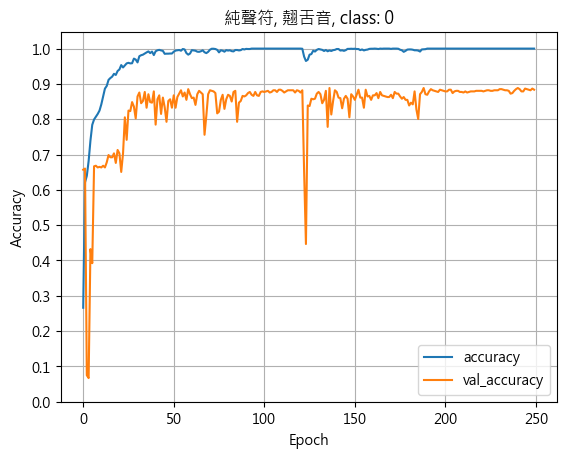

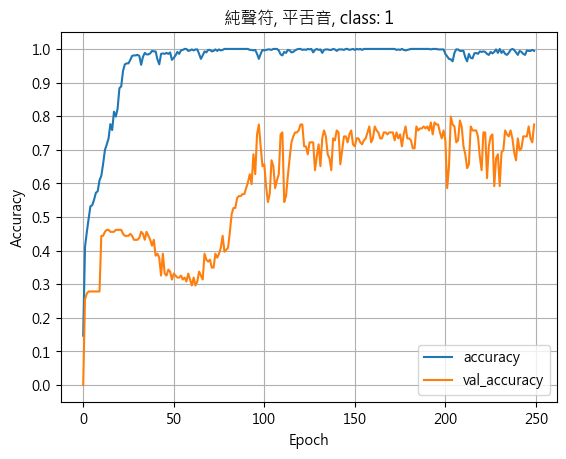

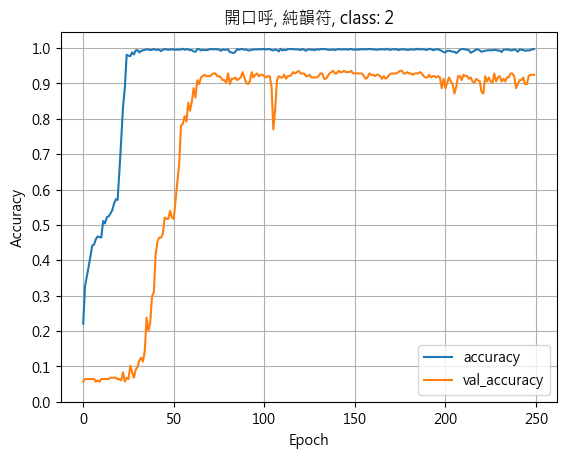

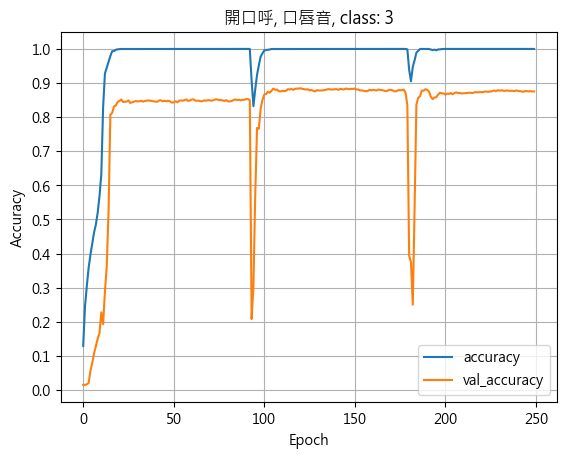

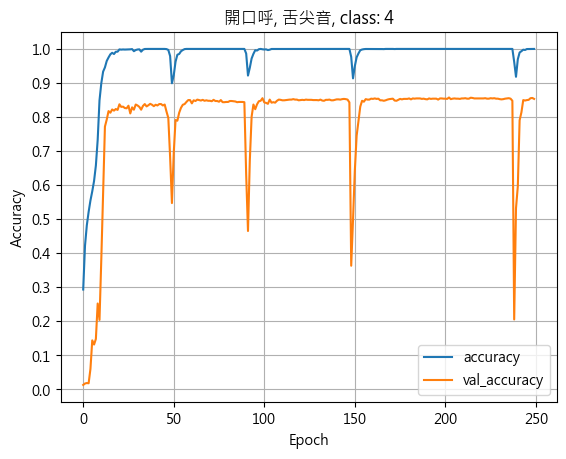

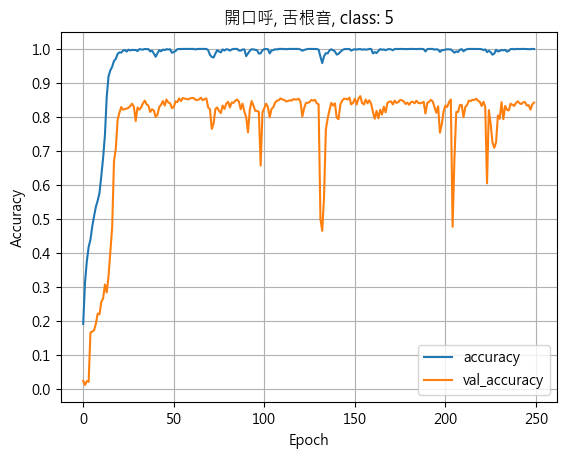

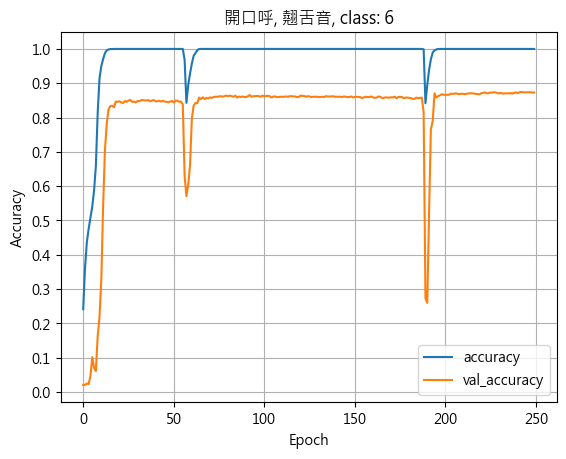

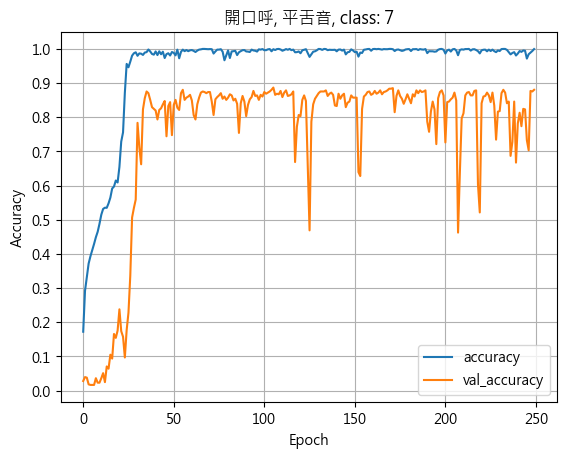

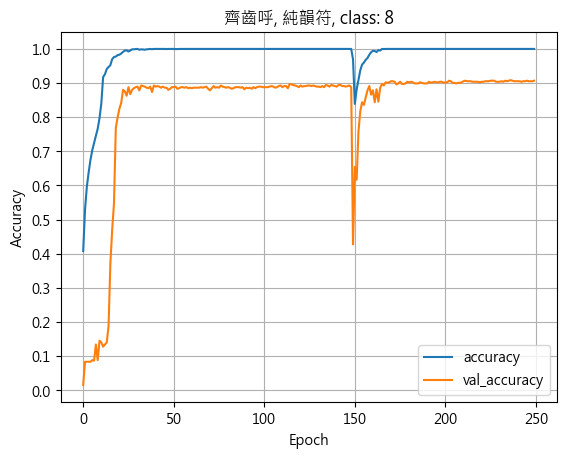

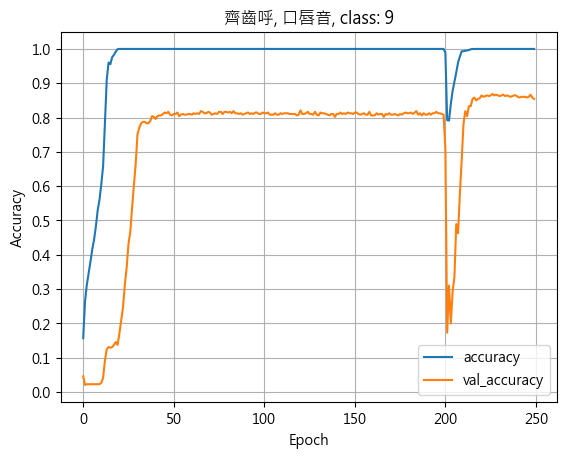

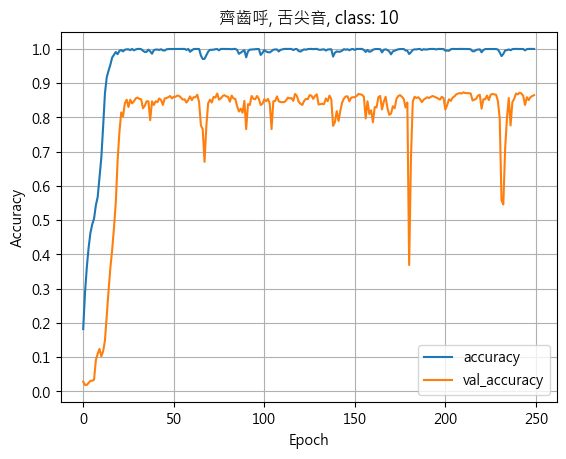

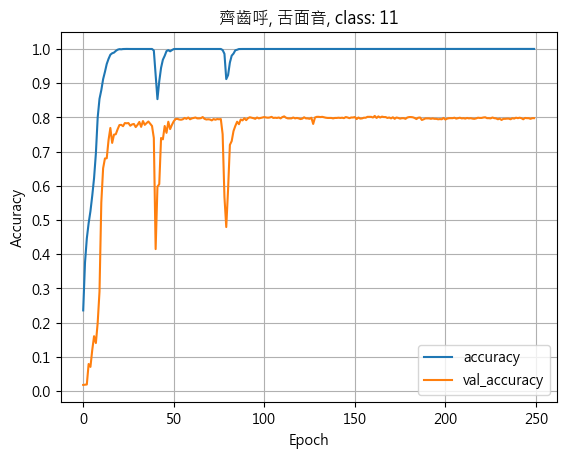

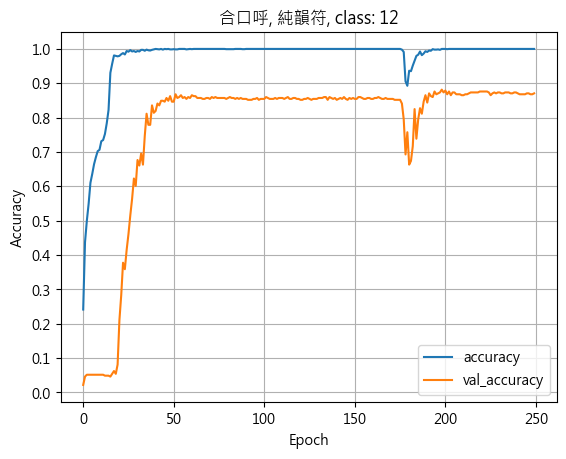

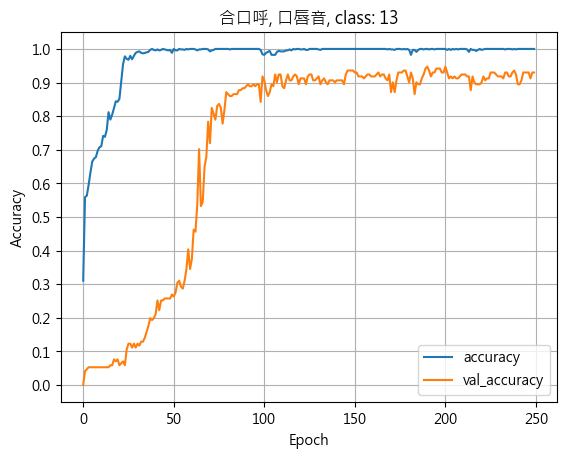

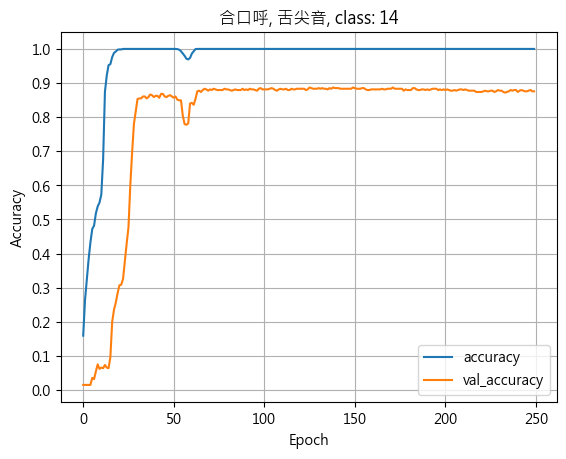

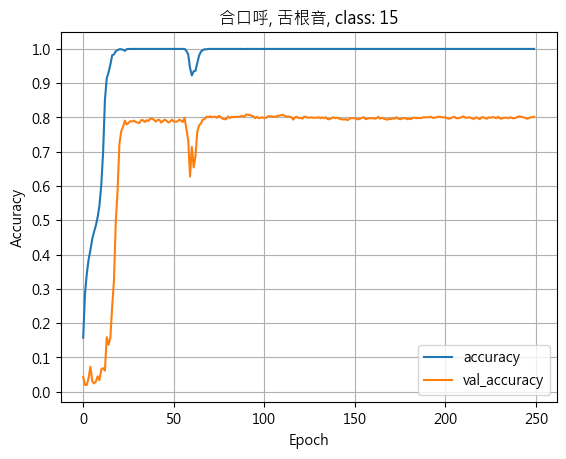

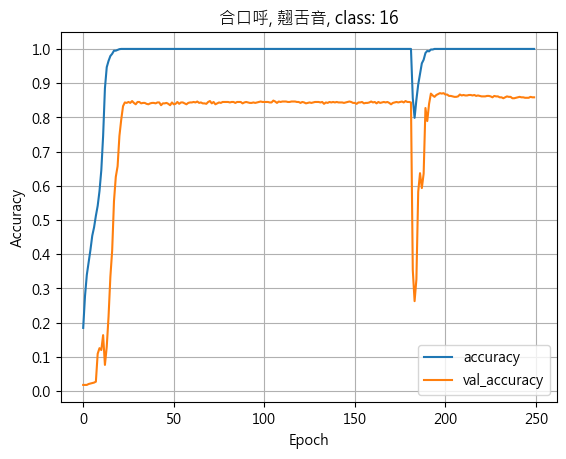

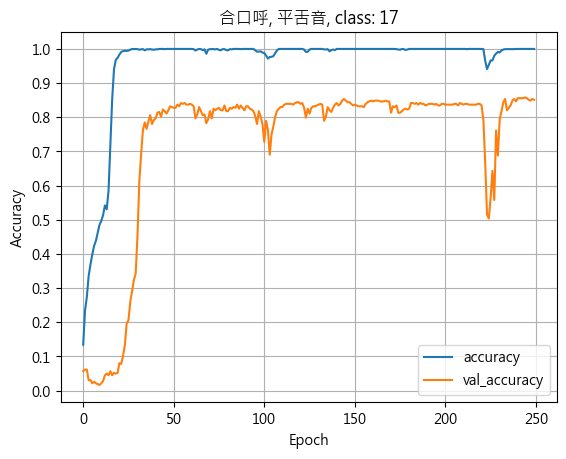

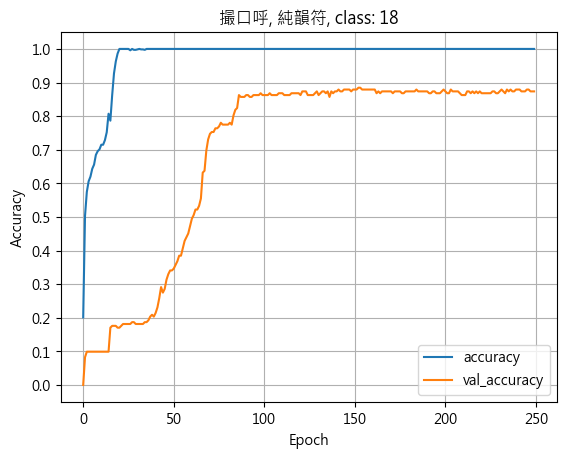

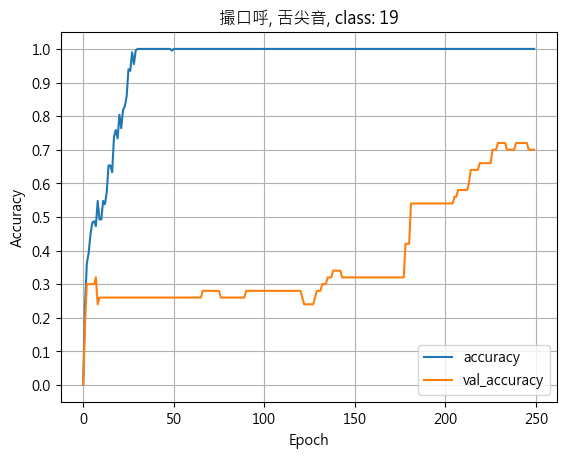

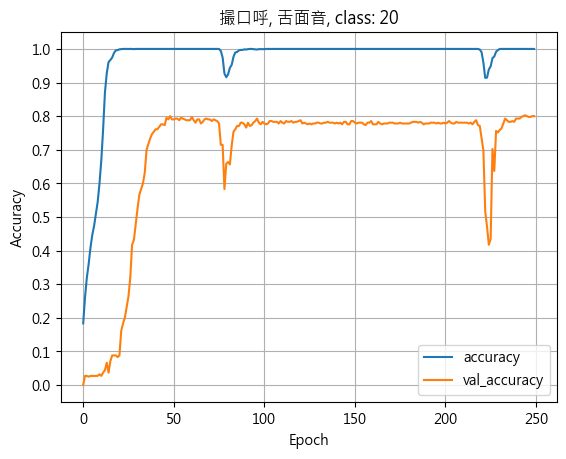

In [11]:
plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei"]
plt.rcParams["axes.unicode_minus"] = False

for class_label, model_train_info in enumerate(model_train_info_list):
    accuracies = model_train_info.history['accuracy']
    val_accuracies = model_train_info.history['val_accuracy']
    
    hu_yin = class_df.loc[class_df["class_label"] == class_label, "hu_yin"].values[0]
    she2_yin = class_df.loc[class_df["class_label"] == class_label, "she2_yin"].values[0]
    plt.title(f"{hu_yin}, {she2_yin}, class: {class_label}")
    
    plt.plot(list(range(epochs)), accuracies, label = "accuracy")
    plt.plot(list(range(epochs)), val_accuracies, label = "val_accuracy")
    plt.legend()
    plt.grid()
    plt.xticks(ticks = list(range(1, epochs + 1))) 
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xticks(ticks=list(range(0, epochs + 1, 50)))
    plt.yticks(ticks=list(np.arange(0, 1 + 0.1, 0.1)))
    plt.show()

In [12]:
best_accuracy_list = list()

for class_label, model_train_info in enumerate(model_train_info_list):
    val_accuracies = model_train_info.history['val_accuracy']
    best_accuracy = max(val_accuracies)
    hu_yin = class_df.loc[class_df["class_label"] == class_label, "hu_yin"].values[0]
    she2_yin = class_df.loc[class_df["class_label"] == class_label, "she2_yin"].values[0]
    print(f"class: {class_label}, {hu_yin}, {she2_yin}, 最高準確率: {best_accuracy}")
    best_accuracy_list.append(best_accuracy)

class: 0, 純聲符, 翹舌音, 最高準確率: 0.8883572816848755
class: 1, 純聲符, 平舌音, 最高準確率: 0.7988165616989136
class: 2, 開口呼, 純韻符, 最高準確率: 0.9358490705490112
class: 3, 開口呼, 口唇音, 最高準確率: 0.8847235441207886
class: 4, 開口呼, 舌尖音, 最高準確率: 0.8573397397994995
class: 5, 開口呼, 舌根音, 最高準確率: 0.8611111044883728
class: 6, 開口呼, 翹舌音, 最高準確率: 0.8745874762535095
class: 7, 開口呼, 平舌音, 最高準確率: 0.8868852257728577
class: 8, 齊齒呼, 純韻符, 最高準確率: 0.9085173606872559
class: 9, 齊齒呼, 口唇音, 最高準確率: 0.8687499761581421
class: 10, 齊齒呼, 舌尖音, 最高準確率: 0.8733572363853455
class: 11, 齊齒呼, 舌面音, 最高準確率: 0.804163932800293
class: 12, 合口呼, 純韻符, 最高準確率: 0.8814015984535217
class: 13, 合口呼, 口唇音, 最高準確率: 0.9473684430122375
class: 14, 合口呼, 舌尖音, 最高準確率: 0.887005627155304
class: 15, 合口呼, 舌根音, 最高準確率: 0.8089261054992676
class: 16, 合口呼, 翹舌音, 最高準確率: 0.8707482814788818
class: 17, 合口呼, 平舌音, 最高準確率: 0.8581560254096985
class: 18, 撮口呼, 純韻符, 最高準確率: 0.8846153616905212
class: 19, 撮口呼, 舌尖音, 最高準確率: 0.7200000286102295
class: 20, 撮口呼, 舌面音, 最高準確率: 0.8024390339851379


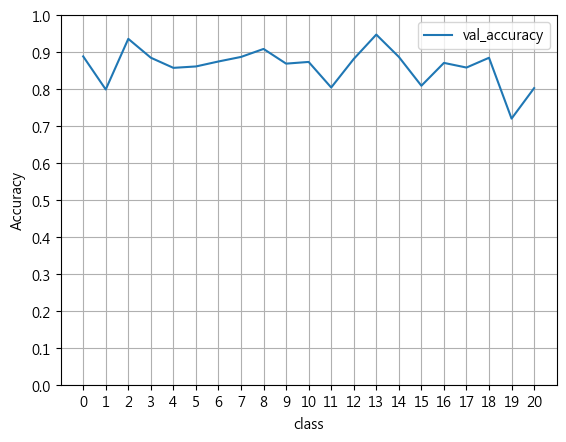

In [13]:
plt.plot(range(len(best_accuracy_list)), best_accuracy_list, label = "val_accuracy")
plt.legend()
plt.grid()
plt.xticks(ticks=list(range(1, len(best_accuracy_list) + 1))) 
plt.xlabel("class")
plt.ylabel("Accuracy")
plt.xticks(ticks=range(len(best_accuracy_list)))
plt.yticks(ticks=list(np.arange(0, 1 + 0.1, 0.1)))
plt.show()

In [15]:
model_dir_path = ".\\method2_layer2_models"
if not os.path.exists(model_dir_path):
    os.mkdir(model_dir_path)
    
for i, model in enumerate(model_list):
    model.save(filepath=f"{model_dir_path}\\class_{i}_model.h5")